# Manual Labeling/Correction

In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

from sarcgraph.sg import SarcGraph

In [3]:
file_path = "samples/hiba/sample_7.tif"
tiff_image = PIL.Image.open(file_path)
numpy_image = np.array(tiff_image)

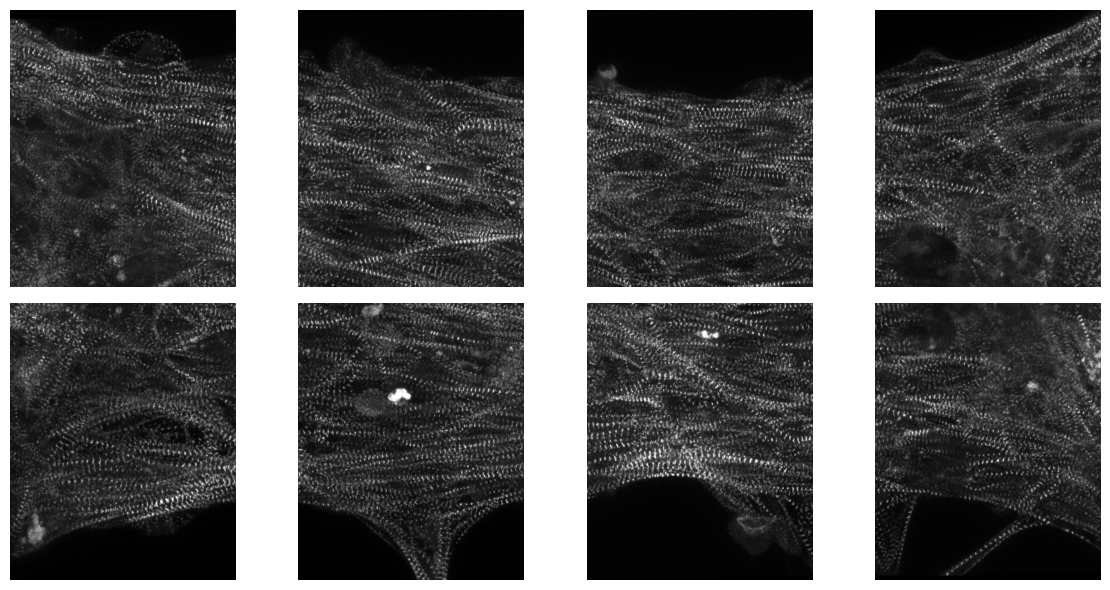

In [4]:
def split_array(arr):
    # Calculate the sizes for splitting the array
    rows, cols = arr.shape
    split_rows = 2
    split_cols = 4
    row_size = rows // split_rows
    col_size = cols // split_cols

    # Split the array row-wise and then column-wise
    row_splits = np.array_split(arr, split_rows, axis=0)
    result = [np.array_split(row_split, split_cols, axis=1) for row_split in row_splits]

    # Flatten the result list
    result = [subarray for row_arrays in result for subarray in row_arrays]

    return result

images = split_array(numpy_image)

# Define the grid size
rows, cols = 2, 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

# Iterate through the rows and columns, plotting each image
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        axes[i, j].imshow(images[index], cmap='gray')
        axes[i, j].axis('off')  # Disable axis labels

# Display the images
plt.tight_layout()
plt.show()

In [4]:
# Run SarcGraph on all images for zdisc_segmentation
zdiscs = []
for i in range(8):
    sg_img = SarcGraph(output_dir=f'output/img-{i}', file_type="image")
    zdiscs.append(sg_img.zdisc_segmentation(raw_frames=images[i]))

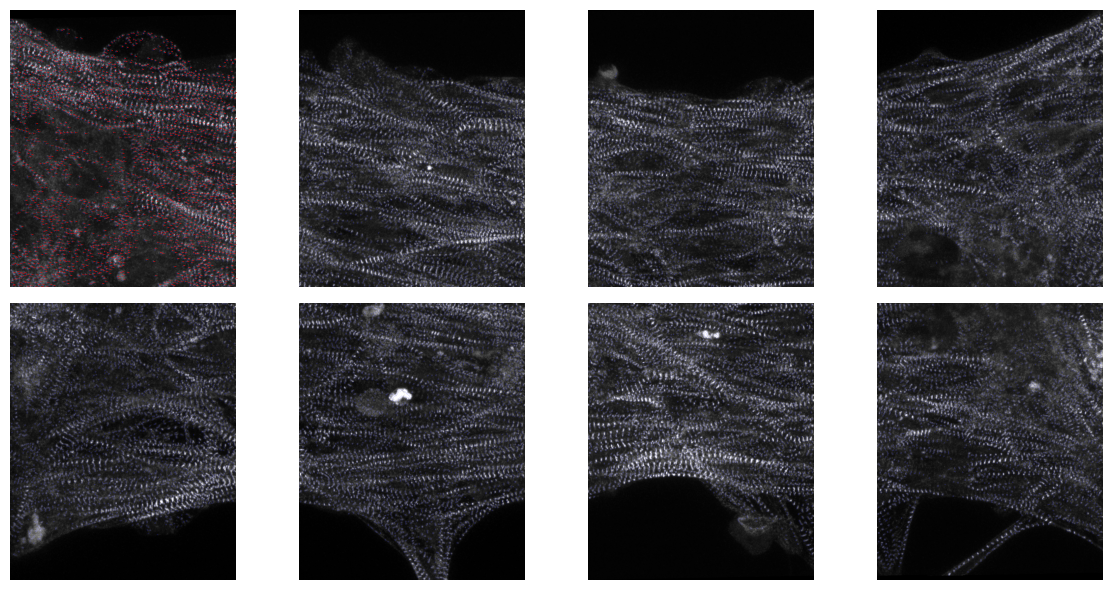

In [12]:
# Define the grid size
rows, cols = 2, 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

font_size = 0.5  # Adjust this value to change the text size
font_color = 'red'

zdiscs_x = zdiscs[0].x.to_numpy()
zdiscs_y = zdiscs[0].y.to_numpy()

numbers = [1495, 1514, 1533, 1551, 1577, 1597, 1636, 1668, 1690, 1728]
array_2d = np.array([numbers[i:i+2] for i in range(0, len(numbers)-1, 1)])

# Iterate through the rows and columns, plotting each image
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        contours = np.load(f'output/img-{index}/contours.npy', allow_pickle=True)
        axes[i, j].imshow(images[index], cmap='gray')
        for c in contours[0]:
            axes[i, j].plot(c[:, 1], c[:, 0], color='b', lw=0.1, alpha=0.5)
        if i == 0 and j == 0:
            for idx, loc in enumerate(zip(zdiscs_x, zdiscs_y)):
                x, y = loc
                axes[i, j].text(y, x, str(idx), fontsize=font_size, color=font_color)
            for ids in array_2d:
                x1, y1 = zdiscs_x[ids[0]], zdiscs_y[ids[0]]
                x2, y2 = zdiscs_x[ids[1]], zdiscs_y[ids[1]]
                axes[i, j].plot([y1, y2], [x1, x2], color='green', lw=0.1)
        axes[i, j].axis('off')  # Disable axis labels

# Display the images
plt.tight_layout()
plt.savefig('test3.png', dpi=1200)
plt.show()


# Machine Learning Part

- Partitioned the original image into 8 smaller images.
- Run sarcgraph on one of the smaller images and detect sarcomeres.
- Prepare the framework for manual sarcomere correction.
- Train ML algorithms to learn proper score functions using the manual labels and auto-detected labels.
  - Manually engineer features for the ML algorithm.

In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

from sarcgraph.sg import SarcGraph

In [2]:
# Load the original image into a numpy array
file_path = "samples/hiba/sample_7.tif"
tiff_image = PIL.Image.open(file_path)
numpy_image = np.array(tiff_image)

In [3]:
# Split the image into 8 smaller images
def split_array(arr):
    # Calculate the sizes for splitting the array
    rows, cols = arr.shape
    split_rows = 2
    split_cols = 4
    row_size = rows // split_rows
    col_size = cols // split_cols

    # Split the array row-wise and then column-wise
    row_splits = np.array_split(arr, split_rows, axis=0)
    result = [np.array_split(row_split, split_cols, axis=1) for row_split in row_splits]

    # Flatten the result list
    result = [subarray for row_arrays in result for subarray in row_arrays]

    return result

images = split_array(numpy_image)

In [4]:
# choose one of the 8 images
img = images[0]

# Run sarcomere detection algorithm on this image
output_dir = "results-ml/img-1"
sg_img = SarcGraph(output_dir, 'image')
zdiscs = sg_img.zdisc_segmentation(raw_frames=img)
sarcs, _ = sg_img.sarcomere_detection(segmented_zdiscs=zdiscs)

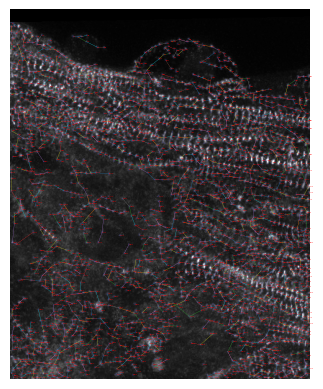

In [5]:
# Load contours of detected zdiscs
contours = np.load(f"{output_dir}/contours.npy", allow_pickle=True)

# figure configuration
font_size = 1
font_color = 'r'

ax = plt.axes()
ax.axis('off')

# Plot the raw frame
plt.imshow(img, cmap='gray')

# Visualize detected zdiscs with blue contours
for c in contours[0]:
    plt.plot(c[:, 1], c[:, 0], color='b', lw=0.1, alpha=0.5)

# Visualize detected sarcomeres by connecting the corresponding zdiscs with a green line
for _, sarc in sarcs.iterrows():
    zdisc_id_1 = int(sarc.zdiscs.split(',')[0])
    zdisc_1 = zdiscs[zdiscs.particle == zdisc_id_1]
    zdisc_id_2 = int(sarc.zdiscs.split(',')[1])
    zdisc_2 = zdiscs[zdiscs.particle == zdisc_id_2]
    plt.plot([float(zdisc_1.y), float(zdisc_2.y)], [float(zdisc_1.x), float(zdisc_2.x)], lw=0.2)

# Add zdisc ids to the figure
for _, zdisc in zdiscs.iterrows():
    plt.text(zdisc.y, zdisc.x, str(zdisc.particle), fontsize=font_size, color=font_color)

plt.savefig('results-ml/img-1/sarcs-vis.png', dpi=1200)

### Feature Selection

Manually form zdisc feature vectors and prepare it for training an ML algorithm

**1. Pixels Intensity:**

Measure the average or peak fluorescence intensity within each z-disc region. This can help distinguish between different levels of signal or particle concentration.

In [167]:
import cv2
import numpy as np

# Load detected contours and the raw frame
raw_frame = np.load('results-ml/img-1/raw-frames.npy')[0, :, :, 0]
contours = np.load('results-ml/img-1/contours.npy', allow_pickle=True)[0]

# Draw the contour as a filled polygon on the mask
intensity_features = np.zeros((len(contours), 4))
for idx, cnt in enumerate(contours):
    # Create a blank mask with the same dimensions as your image
    mask = np.zeros_like(raw_frame, dtype=np.uint8)
    
    # Create a mask for each zdisc
    cnt = np.round(cnt)[:, ::-1].reshape(-1, 1, 2).astype(np.int32)
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    
    # Extract the intensity values inside the contour
    raw_frame = raw_frame.astype('uint8')
    zdisc_intensity = cv2.bitwise_and(raw_frame, mask)
    
    # Average intensity
    avg_intensity = np.mean(zdisc_intensity[zdisc_intensity > 0])

    # Standard deviation intensity
    std_intensity = np.std(zdisc_intensity[zdisc_intensity > 0])

    # Peak intensity
    peak_intensity = np.max(zdisc_intensity[zdisc_intensity > 0])
    
    # Minimum intensity
    min_intensity = np.min(zdisc_intensity[zdisc_intensity > 0])
    
    # Zdiscs intensity feature vector
    intensity_features[idx, :] = [avg_intensity, std_intensity, peak_intensity, min_intensity]


**2. Ellipse Fitting:**

Calculate the eccentricity of each z-disc, which is a measure of how elongated the shape is. This can provide insights into the aspect ratio and orientation.

**3. Compactness:**

Assess the compactness (perimeter^2 / area) to quantify how regular or irregular the z-disc shapes are.

**4. Convexity:**

Determine the convexity (convex hull area / object area) to identify if the z-discs have any concave regions.

In [168]:
import cv2
import numpy as np

# Load detected contours and the raw frame
raw_frame = np.load('results-ml/img-1/raw-frames.npy')[0, :, :, 0]
contours = np.load('results-ml/img-1/contours.npy', allow_pickle=True)[0]

ellipse_features = np.zeros((len(contours), 8))
for idx, cnt in enumerate(contours):
    #cnt = np.round(cnt)[:, ::-1].reshape(-1, 1, 2).astype('int32')
    cnt = cnt[:, ::-1].reshape(-1, 1, 2).astype(np.float32)
    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(cnt)

    # Extract the lengths of the major and minor axes of the ellipse
    major_axis = max(ellipse[1])
    minor_axis = min(ellipse[1])

    # Calculate the eccentricity
    eccentricity = np.sqrt(1 - (minor_axis**2) / (major_axis**2))

    # Calculate the area of the contour
    area = cv2.contourArea(cnt)

    # Calculate the convex hull of the contour
    convex_hull = cv2.convexHull(cnt)

    # Calculate the area of the convex hull
    convex_hull_area = cv2.contourArea(convex_hull)

    # Calculate the perimeter (arc length) of the contour
    perimeter = cv2.arcLength(cnt, True)  # 'True' means the contour is closed

    # Calculate the compactness
    compactness = (perimeter**2) / area

    # Calculate the convexity
    convexity = convex_hull_area / area
    
    # Zdisc position, length, width, angle (radian), eccentricity, compactness, convexity
    pos = ellipse[0]
    angle = np.pi * ellipse[2] / 180
    
    ellipse_features[idx] = [pos[0], pos[1], major_axis, minor_axis, angle, eccentricity, compactness, convexity]

#### Features I Haven't Tried:

- Texture features: Extract texture features, such as contrast, homogeneity, energy, and correlation, from the gray-level co-occurrence matrix (GLCM) of the z-disc region.

- Shape descriptors: Use Fourier descriptors, Hu moments, or Zernike moments to capture additional shape information about the z-discs.

- Local features: Use local feature extraction methods like Scale-Invariant Feature Transform (SIFT), Speeded-Up Robust Features (SURF), or Binary Robust Independent Elementary Features (BRIEF) to capture unique local patterns.

- Histogram-based features: Compute color or intensity histograms of the z-disc region to capture distribution information of the fluorescent signals.

### Dataset Creation

Find a list of potential connections

In [198]:
from sklearn.neighbors import NearestNeighbors

# Create an array of zdiscs positions
zdiscs_pos = ellipse_features[:, 0:2]

# Create an array of zdiscs features
zdiscs_features = np.hstack((intensity_features, ellipse_features))

# Instantiate the NearestNeighbors class with 3 neighbors
k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(zdiscs_pos)

# Compute the k nearest neighbors for each z-disc
distances, indices = nbrs.kneighbors(zdiscs_pos)


Create a set of initially detected sarcomeres and use it to find which zdiscs are connected. This will be used to label the dataset.

In [230]:
# Load the dataframe of segmented zdiscs
import pandas as pd

sarcs = pd.read_csv('results-ml/img-1/sarcomeres.csv', index_col=0)

zdisc_pairs = set()

for idx, row in sarcs.iterrows():
    zdisc_pair_str = row['zdiscs']
    zdisc_pair = tuple(sorted([int(idx) for idx in zdisc_pair_str.split(',')]))
    zdisc_pairs.add(zdisc_pair)

In [232]:
# Create the inputs and outputs
keep_zdisc_ids = []
inputs = []
labels = []
for zdisc_id, neighbors_ids in enumerate(indices[:, 1:]):
    for idx, neighbor_id in enumerate(neighbors_ids):
        pair = tuple(sorted([zdisc_id, neighbor_id]))
        if pair in zdisc_pairs:
            labels.append(1)
        else:
            labels.append(0)
        features = np.hstack((zdiscs_features[zdisc_id], zdiscs_features[neighbor_id], distances[zdisc_id, idx+1]))
        inputs.append(features)
        keep_zdisc_ids.append(pair)

inputs = np.array(inputs)
labels = np.array(labels)
keep_zdisc_ids = np.array(keep_zdisc_ids)

In [220]:
# Permute the dataset
perm_indices = np.random.permutation(len(inputs))
inputs = inputs[perm_indices]
labels = labels[perm_indices]
keep_zdisc_ids = keep_zdisc_ids[perm_indices]

### Machine Learning Algorithm Training

Interpretable machine learning models are models that are easily understood by humans, meaning their predictions can be explained and traced back to input features. Some common interpretable ML algorithms include:

1. Logistic Regression: A simple linear model that is well-suited for binary classification problems. It's easy to understand and interpret, as the model coefficients indicate the strength and direction of the relationship between each input feature and the target.

2. Decision Trees: Decision trees learn a series of if-else rules to make predictions. They are highly interpretable, as you can visualize the decision-making process as a flowchart. The downside is that they can be prone to overfitting, but this can be mitigated by pruning techniques or using ensemble methods like Random Forests or Gradient Boosted Trees, which can increase accuracy at the cost of interpretability.

3. k-Nearest Neighbors (k-NN): k-NN is a simple, non-parametric method that works by finding the k nearest neighbors to a given sample and predicting the class based on a majority vote of the neighbors. It's interpretable due to its simplicity but may not perform well in high-dimensional feature spaces or with imbalanced datasets.

4. Rule-based models: Rule-based models, like OneR or RIPPER, learn a set of rules from the data to make predictions. These models can be quite interpretable, as you can directly analyze the rules to understand the decision-making process.

5. Linear Support Vector Machines (SVM): SVMs with linear kernels can also be considered interpretable, as they find the optimal hyperplane that separates the classes. You can interpret the model by examining the weights assigned to each feature, which determine the hyperplane's orientation. However, SVMs with non-linear kernels are generally less interpretable.

When choosing an interpretable ML algorithm, consider your dataset's characteristics, the required model complexity, and the desired trade-off between interpretability and predictive performance. You can also use techniques like feature selection, feature importance analysis, or model explanation tools (e.g., LIME or SHAP) to enhance the interpretability of your chosen model.

### Decision Tree

In [242]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming your input data is in `X` and labels are in `y`
# Replace these with your actual data
X = inputs
y = labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
# Options to deal with overfitting:
# max_depth=5
# ccp_alpha=0.01
# min_samples_leaf=5

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print(f"Train Accuracy: {accuracy_score(y_train, clf.predict(X_train))}")
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the decision tree (optional)
# from sklearn.tree import export_text
# tree_rules = export_text(clf, feature_names=['f'+str(i) for i in range(X.shape[1])])
# print("\nDecision Tree Rules:")
# print(tree_rules)

Train Accuracy: 0.6969545681477783
Test Accuracy: 0.6939454424484365
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      1034
           1       0.59      0.06      0.11       469

    accuracy                           0.69      1503
   macro avg       0.64      0.52      0.46      1503
weighted avg       0.66      0.69      0.60      1503



In [243]:
# Grid search + cross validation for hyperparametr tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 5, 10, 20],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best parameters found by grid search
clf = grid_search.best_estimator_

In [282]:
# Ensemble Methods (Random Forest)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, max_features="sqrt", random_state=42)
clf = clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=42)

In [288]:
# Ensemble Methods (Gradient Boosted Trees)
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, min_samples_leaf=5, max_features="sqrt", subsample=0.8, random_state=42)
clf = gb_clf.fit(X_train, y_train)

In [289]:
# Evaluate the classifier
print(f"Train Accuracy: {accuracy_score(y_train, clf.predict(X_train))}")
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Test Accuracy:", accuracy)

Train Accuracy: 0.7695123980695623
Test Accuracy: 0.6640053226879574


Visualize how would the end result will look like if we use the trained model:

We need two seperate lists of pairs of zdiscs ids as input. One for those zdiscs that are incorrectly connected. The other for those zdiscs that should be connected.

- Write a method that takes an arbitrary number of pairs of numbers and store them in a list.

In [6]:
def get_pairs():
    pairs_list = []
    while True:
        try:
            num1 = input("Enter first number of pair (or 'q' to quit): ")
            if num1 == 'q':
                break
            num2 = input("Enter second number of pair: ")
            pairs_list.append([int(num1), int(num2)])
        except ValueError:
            print("Invalid input. Please enter a valid integer.")
    return pairs_list

In [7]:
# Provide zdisc ids corresponding to sarcomeres that should be removed
remove_sarcs = get_pairs()

# Provide zdisc ids corresponding to sarcomeres that should be added
add_sarcs = get_pairs()

In [8]:
# Visualize sarcs to be removed/added with red/green lines

In [ ]:
file_path = "samples/hiba/sample_7.tif"
images = load_multipage_tiff(file_path)

# Apply the denoise filter to all images
denoised_images = denoise_images(images)

# Display the first denoised image
denoised_images[0].show()

(array([6.672e+03, 3.295e+03, 4.323e+03, 1.265e+03, 1.539e+03, 4.930e+02,
        6.060e+02, 1.880e+02, 2.140e+02, 6.400e+01, 9.500e+01, 3.800e+01,
        4.800e+01, 1.300e+01, 1.700e+01, 1.200e+01, 1.000e+01, 2.000e+00,
        5.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  8.   ,  11.025,  14.05 ,  17.075,  20.1  ,  23.125,  26.15 ,
         29.175,  32.2  ,  35.225,  38.25 ,  41.275,  44.3  ,  47.325,
         50.35 ,  53.375,  56.4  ,  59.425,  62.45 ,  65.475,  68.5  ,
         71.525,  74.55 ,  77.575,  80.6  ,  83.625,  86.65 ,  89.675,
         92.7  ,  95.725,  98.75 , 101.775, 104.8  , 107.825, 110.85 ,
        113.875, 116.9  , 119.925, 122.95 , 125.975, 129.   ]),
 <BarContainer object of 40 artists>)

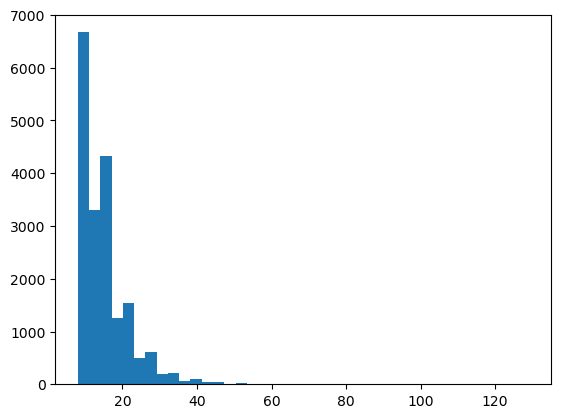

In [168]:
lengths = np.array([len(c) for c in contours[0]])
plt.hist(lengths, 40)

In [132]:
from sarcgraph.sg import SarcGraph

sg_img = SarcGraph(file_type="image")

In [133]:
zdiscs = sg_img.zdisc_segmentation(raw_frames=numpy_image)

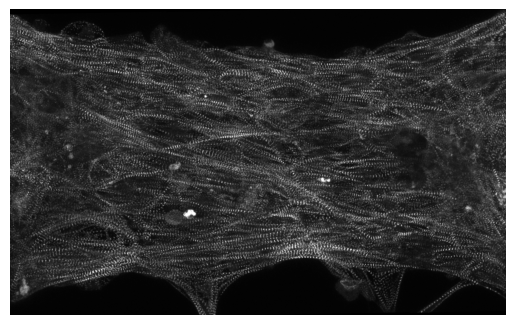

In [160]:
#contours = np.load('test-run/contours.npy', allow_pickle=True)
#zdiscs_f0 = zdiscs[zdiscs.frame == 0]

ax = plt.axes()
ax.axis('off')
plt.imshow(numpy_image, cmap='gray')
#plt.plot(zdiscs_f0.y, zdiscs_f0.x, '.', ms=1, alpha=0.8)

#for cont in contours[0]:
#    plt.plot(cont[:, 1], cont[:, 0], color='r', lw=0.5)

plt.savefig('test2.png', dpi=1200)


In [ ]:
contours = np.load('test-run/contours.npy', allow_pickle=True)
zdiscs_f0 = zdiscs[zdiscs.frame == 0]

ax = plt.axes()
ax.axis('off')
plt.imshow(frame, cmap='gray')
#plt.plot(zdiscs_f0.y, zdiscs_f0.x, '.', ms=1, alpha=0.8)

#for cont in contours[0]:
#    plt.plot(cont[:, 1], cont[:, 0], color='r', lw=0.5)

plt.savefig('bingying.png', dpi=600)

In [2]:
sg = SarcGraph()

In [104]:
zdiscs = sg.zdisc_segmentation('samples/bingying/AVG_16X_08_4.avi')

In [105]:
import numpy as np
import matplotlib.pyplot as plt

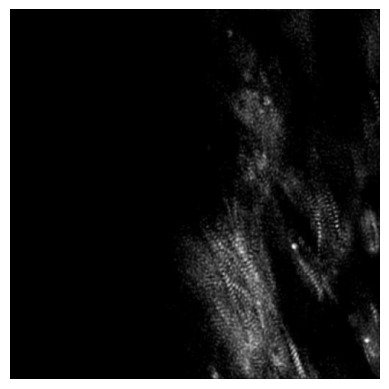

In [106]:
frame = np.load('test-run/raw-frames.npy')[0, :, :, 0]
contours = np.load('test-run/contours.npy', allow_pickle=True)
zdiscs_f0 = zdiscs[zdiscs.frame == 0]

ax = plt.axes()
ax.axis('off')
plt.imshow(frame, cmap='gray')
#plt.plot(zdiscs_f0.y, zdiscs_f0.x, '.', ms=1, alpha=0.8)

#for cont in contours[0]:
#    plt.plot(cont[:, 1], cont[:, 0], color='r', lw=0.5)

plt.savefig('bingying.png', dpi=600)

In [41]:
import cv2
import numpy as np
from PIL import Image

In [116]:
def load_multipage_tiff(file_path):
    images = []
    tiff_image = Image.open(file_path)

    for i in range(tiff_image.n_frames):
        tiff_image.seek(i)
        images.append(tiff_image.copy())

    return images

def denoise_images(images, h=10, template_window_size=7, search_window_size=21):
    denoised_images = []

    for image in images:
        # Convert the image to a numpy array
        np_image = np.array(image).astype(np.uint8)

        # Apply the denoise filter
        denoised_image = cv2.fastNlMeansDenoising(np_image, None, h, template_window_size, search_window_size)

        # Convert the denoised image back to PIL Image
        denoised_image = Image.fromarray(denoised_image)

        denoised_images.append(denoised_image)

    return denoised_images

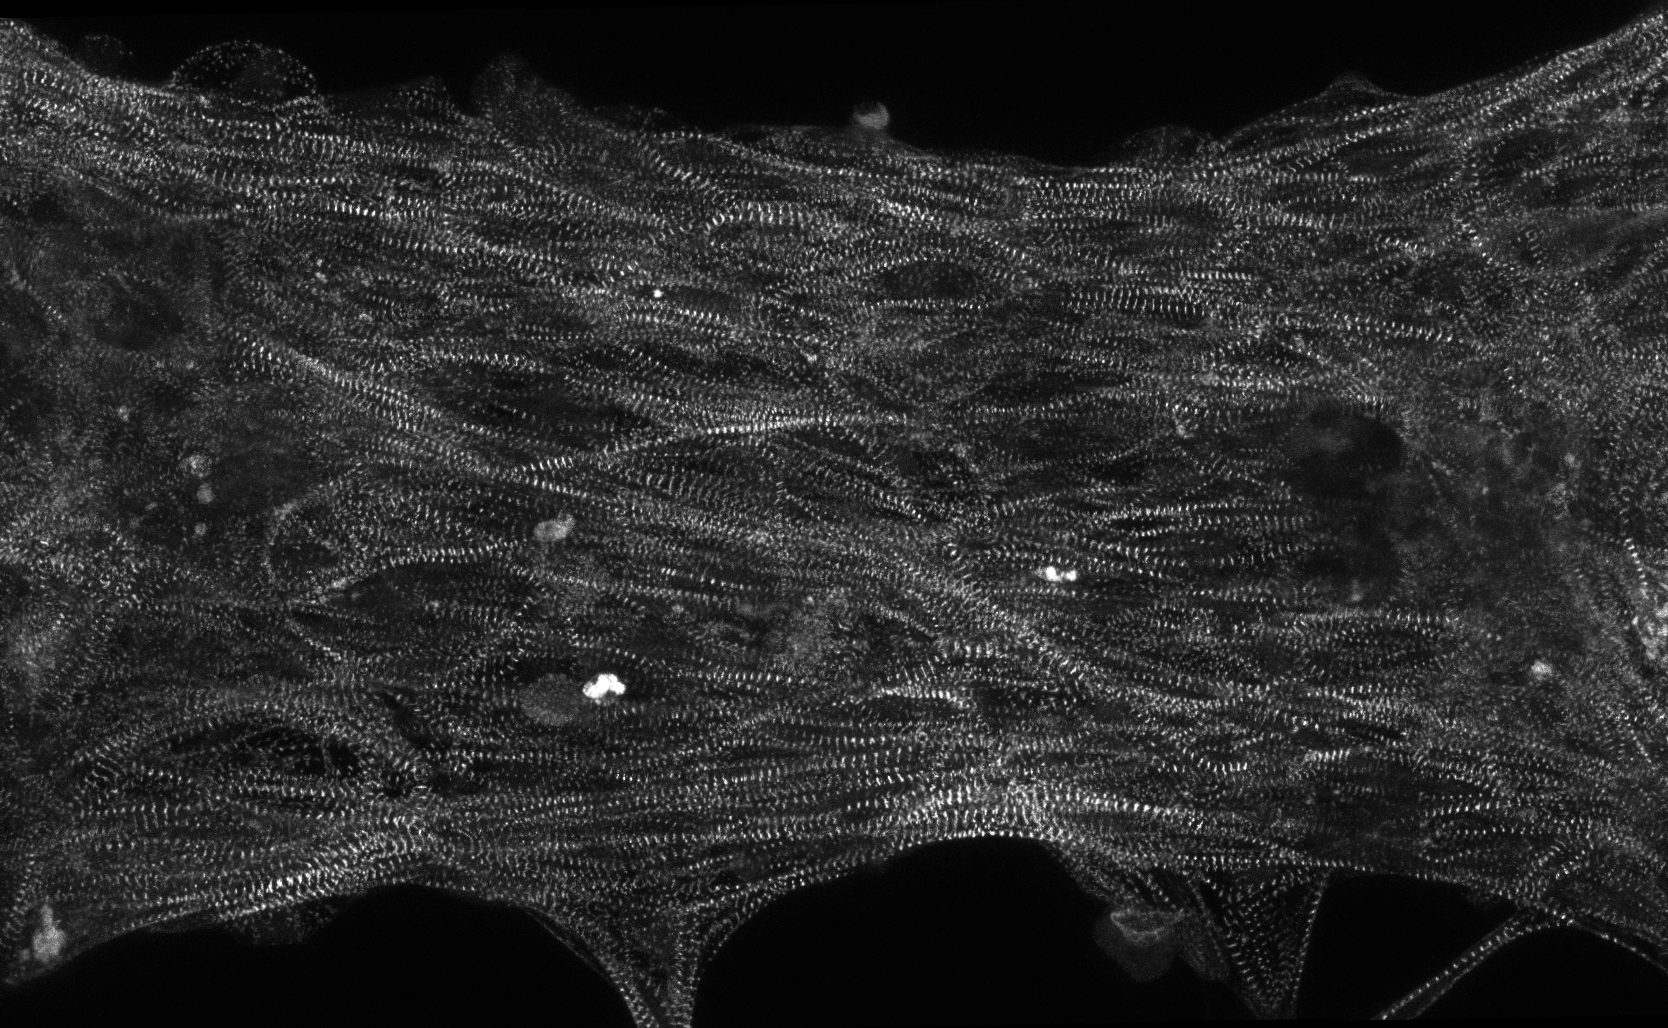

In [121]:
images[0]

In [117]:
file_path = "samples/hiba/sample_7.tif"
images = load_multipage_tiff(file_path)

# Apply the denoise filter to all images
denoised_images = denoise_images(images)

# Display the first denoised image
denoised_images[0].show()

In [110]:
list = []
for img in images:
    list.append(np.array(img))

In [114]:
np.save('images_npy.npy', np.array(list))

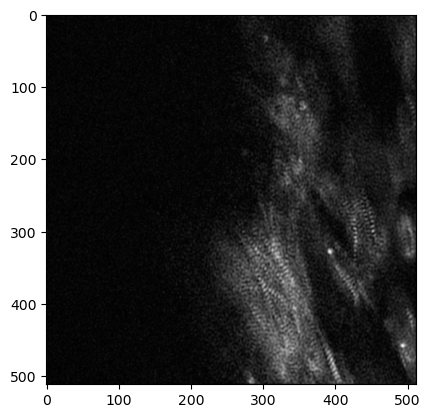

In [115]:
plt.imshow(np.array(list)[0], cmap='gray')

In [48]:
type(images[0])

PIL.Image.Image

In [57]:
import cv2
import numpy as np
from PIL import Image

def load_multipage_tiff(file_path):
    images = []
    tiff_image = Image.open(file_path)

    for i in range(tiff_image.n_frames):
        tiff_image.seek(i)
        images.append(tiff_image.copy())

    return images

def apply_gaussian_filter(images, kernel_size=3, sigma_x=0):
    filtered_images = []

    for image in images:
        # Convert the image to a numpy array with 8-bit depth
        np_image = np.array(image).astype(np.uint8)

        # Apply the Gaussian filter
        filtered_image = cv2.GaussianBlur(np_image, (kernel_size, kernel_size), sigma_x)

        # Convert the filtered image back to PIL Image
        filtered_image = Image.fromarray(filtered_image)

        filtered_images.append(filtered_image)

    return filtered_images

file_path = "samples/bingying/AVG_16X_08_4.tif"
images = load_multipage_tiff(file_path)

# Apply the Gaussian filter to all images
filtered_images = apply_gaussian_filter(images)

# Display the first filtered image
filtered_images[0].show()

In [54]:
images[0].show()

In [58]:
test = images[0]+images[1]

TypeError: unsupported operand type(s) for +: 'Image' and 'Image'

In [66]:
import numpy as np
from PIL import Image

def average_images(images):
    # Convert the first image to a numpy array with float32 depth
    result_image = np.array(images[0]).astype(np.float32)

    # Iterate through the rest of the images
    for image in images[1:]:
        # Convert the image to a numpy array with float32 depth
        np_image = np.array(image).astype(np.float32)

        # Accumulate pixel values
        result_image = np.add(result_image, np_image)

    # Divide the accumulated pixel values by the number of images to get the average
    result_image /= len(images)

    # Convert the average image back to an 8-bit depth image
    result_image = result_image.astype(np.uint8)

    # Convert the average image back to PIL Image
    result_image = Image.fromarray(result_image)

    return result_image

# Average all images
averaged_image = average_images(images)

# Display the averaged image
averaged_image.show()

In [70]:
# Choose the index of the image you want to save
image_index = 0

# Provide the file path and format
output_file_path = 'output_image.png'
output_format = 'PNG'

# Specify the DPI (X and Y resolution)
dpi = (300, 300)

# Convert the image to 8-bit color
converted_image = images[image_index].convert('RGB')

# Save the image
converted_image.save(output_file_path, output_format, dpi=dpi)

In [74]:
sg_img = SarcGraph(file_type='image')

In [76]:
zdiscs = sg_img.zdisc_segmentation(raw_frames=np.array(converted_image).astype(float))

In [78]:
np.array(converted_image).astype(float)

array([[[ 7.,  7.,  7.],
        [18., 18., 18.],
        [13., 13., 13.],
        ...,
        [40., 40., 40.],
        [54., 54., 54.],
        [38., 38., 38.]],

       [[ 7.,  7.,  7.],
        [16., 16., 16.],
        [13., 13., 13.],
        ...,
        [33., 33., 33.],
        [52., 52., 52.],
        [42., 42., 42.]],

       [[10., 10., 10.],
        [11., 11., 11.],
        [ 8.,  8.,  8.],
        ...,
        [30., 30., 30.],
        [46., 46., 46.],
        [40., 40., 40.]],

       ...,

       [[ 4.,  4.,  4.],
        [ 8.,  8.,  8.],
        [ 6.,  6.,  6.],
        ...,
        [55., 55., 55.],
        [55., 55., 55.],
        [33., 33., 33.]],

       [[ 5.,  5.,  5.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [48., 48., 48.],
        [49., 49., 49.],
        [27., 27., 27.]],

       [[10., 10., 10.],
        [15., 15., 15.],
        [ 8.,  8.,  8.],
        ...,
        [45., 45., 45.],
        [51., 51., 51.],
        [30., 30., 30.]]

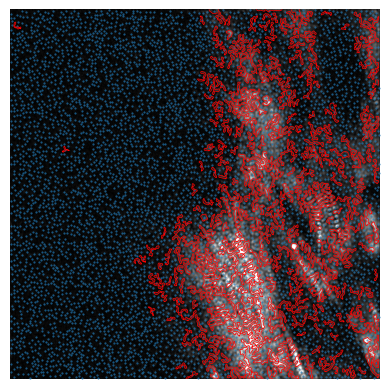

In [103]:
frame = np.array(converted_image).astype(float)
contours = np.load('test-run/contours.npy', allow_pickle=True)
zdiscs_f0 = zdiscs[zdiscs.frame == 0]

ax = plt.axes()
ax.axis('off')
plt.imshow(frame/255, cmap='gray')
plt.plot(zdiscs_f0.y, zdiscs_f0.x, '.', ms=1, alpha=0.8)

for cont in contours[0]:
    if len(cont) > 40:
        plt.plot(cont[:, 1], cont[:, 0], color='r', lw=0.5)

plt.savefig('bingying.png', dpi=600)

In [86]:
lens = []
for cont in contours[0]:
    lens.append(len(cont))

(array([2.707e+03, 1.566e+03, 4.180e+02, 2.330e+02, 1.410e+02, 7.500e+01,
        5.700e+01, 4.100e+01, 4.000e+01, 2.600e+01, 1.100e+01, 2.900e+01,
        1.500e+01, 1.000e+01, 1.300e+01, 7.000e+00, 9.000e+00, 7.000e+00,
        4.000e+00, 2.000e+00, 8.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  8.  ,  14.62,  21.24,  27.86,  34.48,  41.1 ,  47.72,  54.34,
         60.96,  67.58,  74.2 ,  80.82,  87.44,  94.06, 100.68, 107.3 ,
        113.92, 120.54, 127.16, 133.78, 140.4 , 147.02, 153.64, 160.26,
        166.88, 173.5 , 180.12, 186.74, 193.36, 199.98, 206.6 , 213.22,
        219.84, 226.46, 233.08, 239.7 , 246.32, 252.94, 259.56, 266.18,
        272.8 , 

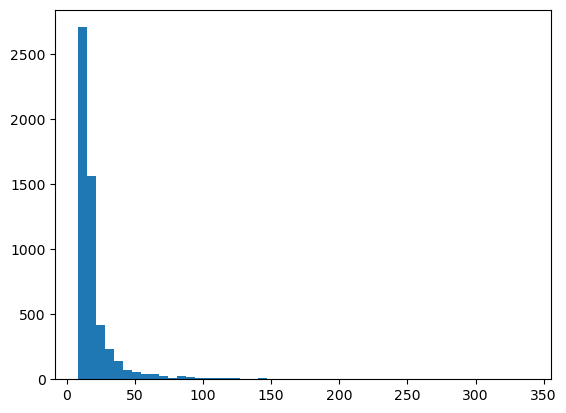

In [100]:
plt.hist(lens, bins=50)